## Author: Akash and Ayush

### Spatial Correlations Between Redlining Index, Rental Index and Minority Populations

Data Source: Redlining Shapefiles (Uni. of Richmond), Rental Prioritisation Index (Urban Institute), Redline and ACS intersection geojson generated using the spatial outlining step

In [ ]:
#Importing all needed libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
from scipy.stats import spearmanr
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
rent_data = gpd.read_file('/datasets/rent_prioritisation/housing_index_state_adj.geojson')
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
cali_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson')
cali_rent_data = rent_data.merge(cali_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

In [ ]:
cali_rent_data.head()

,GEOID,state_name,county_name,state_fips,county_fips,perc_cost_burdened_under_35k,perc_overcrowding_renter_1.50_or_more,perc_unemployed_laborforce,perc_renters,perc_poverty_12mnth,...,z_score_perc_person_of_color_quantile,z_score_perc_public_assistance_quantile,z_score_perc_foreign_born_quantile,z_score_perc_30hamfi_quantile,z_score_perc_low_income_jobs_lost_quantile,num_ELI,grayed_out,geometry,reweighted_redline_index,ordinal_value
0,6.067007e+09,California,Sacramento County,06,06067,0.586696,0.033911,0.178437,0.673797,0.411133,...,0.53,0.42,0.29,0.89,0.30,530.0,0.0,"MULTIPOLYGON (((-121.47556 38.59665, -121.4729...",2.832266,3
1,6.067000e+09,California,Sacramento County,06,06067,0.804124,0.000000,0.031511,0.273850,0.062599,...,0.11,0.40,0.03,0.17,0.60,45.0,0.0,"MULTIPOLYGON (((-121.45047 38.57128, -121.4478...",2.771657,3
2,6.067000e+09,California,Sacramento County,06,06067,0.448203,0.013618,0.027195,0.743071,0.136848,...,0.22,0.36,0.06,0.47,0.67,340.0,0.0,"MULTIPOLYGON (((-121.47619 38.58180, -121.4747...",3.166501,4
3,6.037550e+09,California,Los Angeles County,06,06037,0.831858,0.060367,0.035970,0.328732,0.039739,...,0.71,0.32,0.68,0.06,0.53,25.0,0.0,"MULTIPOLYGON (((-118.11354 33.95430, -118.1116...",3.000000,3
4,6.037551e+09,California,Los Angeles County,06,06037,0.473684,0.025373,0.077564,0.303442,0.026775,...,0.68,0.33,0.73,0.44,0.51,145.0,0.0,"MULTIPOLYGON (((-118.12323 33.93708, -118.1218...",2.000000,2


In [ ]:
#Reading all datasets

#Rental Prioritisation Index Data
rent_data = gpd.read_file('/datasets/rent_prioritisation/housing_index_state_adj.geojson')
rent_data['GEOID'] = rent_data['GEOID'].astype(float)

#Reading the redlining data made available by the Mapping Inequality Project
redline_data = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/redlining_all/shapefile/holc_ad_data.shp')

#Subsetting rental prioritisation data for only minority population details
minorities_data = rent_data[['GEOID','county_name','state_name','perc_person_of_color','geometry']]

#California Data
cali_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson')
cali_rent_data = rent_data.merge(cali_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#NY Data
ny_redline = gpd.read_file('/work/COVIDRedlining/data/new york/ny_redlined_numerical_values.geojson')
ny_redline['GEOID'] = ny_redline['GEOID'].astype(object)
ny_rent_data = rent_data.merge(ny_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Chicago Data
chicago_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/chicago/chicago_redlined_numerical_values.geojson')
chicago_rent_data = rent_data.merge(chicago_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Dallas Data
dallas_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/dallas/dallas_redlined_numerical_values.geojson')
dallas_rent_data = rent_data.merge(dallas_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Detroit Data
detroit_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/detroit/detroit_redlined_numerical_values.geojson')
detroit_rent_data = rent_data.merge(detroit_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Minneapolis Data
minneapolis_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/minneapolis/minneapolis_redlined_numerical_values.geojson')
minneapolis_rent_data = rent_data.merge(minneapolis_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Newark Data
newark_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/newark/newark_redlined_numerical_values.geojson')
newark_rent_data = rent_data.merge(newark_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Tampa Data
tampa_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/tampa/tampa_redlined_numerical_values.geojson')
tampa_rent_data = rent_data.merge(tampa_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Atlanta Data
atlanta_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/atlanta/atlanta_redlined_numerical_values.geojson')
atlanta_rent_data = rent_data.merge(atlanta_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Boston Data
boston_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson')
boston_rent_data = rent_data.merge(boston_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Houston Data
houston_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/houston/houston_redlined_numerical_values.geojson')
houston_rent_data = rent_data.merge(houston_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#Nashville Data
nashville_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/nashville/nashville_redlined_numerical_values.geojson')
nashville_rent_data = rent_data.merge(nashville_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

#St. Louis Data
stlouis_redline = gpd.read_file('/home/jovyan/work/COVIDRedlining/data/stlouis/stlouis_redlined_numerical_values.geojson')
stlouis_rent_data = rent_data.merge(stlouis_redline[['GEOID','reweighted_redline_index','ordinal_value']],how='inner',on='GEOID')

In [ ]:
#Function for visualising rental and redlining maps for each city
def rental_redline_map(y1,y2,x1,x2,city,state_redline):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 15))

    ax1.set_title('Rental Prioritisation'+city, fontsize=18)
    rent_data.plot(ax=ax1, column='total_index_quantile', legend = True, linewidth=.6, edgecolor='0.2', cmap='coolwarm')

    ax2.set_title('Redline Index', fontsize=18)
    state_redline.plot(ax=ax2, column='ordinal_value', legend = True, linewidth=.6, edgecolor='0.2', cmap='coolwarm')

    ax1.set_ylim(y1,y2)
    ax1.set_xlim(x1,x2)

    ax2.set_ylim(y1,y2)
    ax2.set_xlim(x1,x2)

In [ ]:
#Function for visualising rental index and minority populations for each city
def minority_rental_map(y1,y2,x1,x2,city):
    f, (ax1,ax2) = plt.subplots(1,2, figsize=(15, 15))

    ax1.set_title('Minority Distribution'+city, fontsize=18)
    minorities_data.plot(ax=ax1, column='perc_person_of_color', legend = True, linewidth=.6, edgecolor='0.2',cmap='coolwarm')

    ax2.set_title('Rental Prioritisation in'+city, fontsize=18)
    rent_data.plot(ax= ax2, column = 'total_index_quantile',cmap='coolwarm',linewidth=.6, edgecolor='0.2',legend=True)

    ax1.set_ylim(y1, y2)
    ax1.set_xlim(x1,x2)

    ax2.set_ylim(y1,y2)
    ax2.set_xlim(x1,x2)

In [ ]:
#Function for calculating spatial and spearman correlation between rental and redlining index
def rental_redline_corr(counties,state_rent_data,t=None,state_name=None):

    county = state_rent_data[state_rent_data['county_name'].isin(counties)]
    county = county.dropna()

    if(state_name!=None):
        county = county[(county['state_name']==state_name)]

    if t!=None:
        county = county.loc[~county.GEOID.isin(t)]

    y = county['ordinal_value'].values
    w = Queen.from_dataframe(county)
    w.transform = 'R'
    x = county['total_index_quantile'].values
    moran = Moran(y,w)
    moran_loc = Moran_Local(y, w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)
    # return(moran_bv.I)
    # print("Spearman Correlation Redline Index and Rental Assistance")
    coef, p = spearmanr(county['total_index_quantile'], county['ordinal_value'])
    return(moran_bv.I,coef,p)

In [ ]:
#Function for calculating spatial correlation between rental index and minority populations
def correlation_racial_rental(counties,state_name=None,t=None):
    county = rent_data[(rent_data['county_name'].isin(counties))]
    if(state_name!=None):
        county = county[(county['state_name']==state_name)]
    if(t!=None):
        county = county.loc[~county.GEOID.isin(t)]
    y = county['perc_person_of_color'].values
    w = Queen.from_dataframe(county)
    w.transform = 'R'
    x = county['total_index_quantile'].values
    moran = Moran(y,w)
    moran_loc = Moran_Local(y, w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)
    return(moran_bv.I)

In [ ]:
#Function for generating and visualising maps and correlation results for each city
def results(city):

    state_name=None
    t=None

    if (city=='New York'):
        flag=1
        y1,y2,x1,x2=40.506299, 40.893601,-74.259376, -73.725166
        counties= ['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County']
        t=['36061000100']
        state_redline=ny_redline
        rent_data=ny_rent_data
    elif (city=='Los Angeles'):
        flag=1
        y1,y2,x1,x2=33.703996, 34.109748,-118.553885, -118.099326
        counties= ['Los Angeles County']
        t=['6037401311']
        state_redline=cali_redline
        rent_data=cali_rent_data
    elif (city=='San Francisco'):
        flag=1
        y1,y2,x1,x2=37.709061, 37.808676,-122.518342, -122.354233
        counties= ['San Francisco County']
        t=['06075980401']
        state_redline=cali_redline
        rent_data=cali_rent_data
    elif (city=='Chicago'):
        flag=1
        y1,y2,x1,x2=41.653128, 41.892277,-87.684688, -87.508906
        counties= ['Cook County']
        state_name='Illinois'
        state_redline=chicago_redline
        rent_data=chicago_rent_data
    elif (city=='Detroit'):
        flag=1
        y1,y2,x1,x2=42.244090, 42.403499,-83.243609, -82.898913
        counties= ['Wayne County']
        state_name='Michigan'
        state_redline=detroit_redline
        rent_data=detroit_rent_data
    elif (city=='Minneapolis'):
        flag=1
        y1,y2,x1,x2=44.842875, 45.019335,-93.355556,-93.133770
        counties= ['Hennepin County']
        state_redline=minneapolis_redline
        rent_data=minneapolis_rent_data
    elif (city=='Newark'):
        flag=1
        y1,y2,x1,x2=40.657722, 40.795098,-74.252472,-74.116516
        counties= ['Essex County']
        state_name='New Jersey'
        state_redline=newark_redline
        rent_data=newark_rent_data
    elif (city=='Dallas'):
        flag=1
        y1,y2,x1,x2=32.645012, 32.902506,-96.914445, -96.628801
        counties= ['Dallas County']
        state_name='Texas'
        state_redline=dallas_redline
        rent_data=dallas_rent_data
    elif (city=='Atlanta'):
        flag=1
        y1,y2,x1,x2=33.614400, 33.869057,-84.570093, -84.353113
        counties= ['Fulton County']
        state_redline=atlanta_redline
        rent_data=atlanta_rent_data
    elif (city=='Boston'):
        flag=1
        y1,y2,x1,x2=42.261061, 42.400148,-71.128787,-70.983219
        counties= ['Suffolk County']
        state_name='Massachusetts'
        state_redline=boston_redline
        rent_data=boston_rent_data
    elif (city=='Houston'):
        flag=1
        y1,y2,x1,x2=29.568679, 29.885900,-95.541229, -95.141602
        counties= ['Harris County']
        state_name='Texas'
        state_redline=houston_redline
        rent_data=houston_rent_data
    elif (city=='Nashville'):
        flag=1
        y1,y2,x1,x2=36.099351, 36.224083,-86.875063, -86.682802
        counties= ['Davidson County']
        state_name='Tennessee'
        state_redline=nashville_redline
        rent_data=nashville_ren_data
    elif (city=='St. Louis'):
        flag=1
        y1,y2,x1,x2=38.530442, 38.763186,-90.348129, -90.165482
        counties= ['St. Louis County']
        state_redline=stlouis_redline
        rent_data=stlouis_rent_data
    else:
        flag=0
        print("Please enter valid city")
    
    if(flag==1):

        print("************* " + city + " ***************")

        print("Racial Minority and Rental Assistance Correlation")
        print(correlation_racial_rental (counties,state_name,t))

        print("Rental Assistance and Redline Correlation")
        print(rental_redline_corr(counties,rent_data,t,state_name)[0])

        print("Spearman Correlation Redline Index and Rental Assistance")
        print(rental_redline_corr(counties,rent_data,t,state_name)[1:])

        
        #plots
        f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(20, 12))

        ax1.set_title('Minority Distribution', fontsize=18)
        minorities_data.plot(ax=ax1, column='perc_person_of_color', legend = True, linewidth=.6, edgecolor='0.2',cmap='coolwarm')

        ax2.set_title('Rental Prioritisation', fontsize=18)
        rent_data.plot(ax=ax2, column='total_index_quantile', legend = True, linewidth=.6, edgecolor='0.2',cmap='coolwarm')

        ax3.set_title('Redlining', fontsize=18)
        redline_data.plot(ax= ax3, column = 'holc_grade',categorical=True,cmap='coolwarm',linewidth=.6, edgecolor='0.2',legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':6,'frameon':False})

        ax4.set_title('Redline Index', fontsize=18)
        state_redline.plot(ax=ax4, column='ordinal_value', legend = True, linewidth=.6, edgecolor='0.2', cmap='coolwarm')

        ax1.set_ylim(y1,y2)
        ax1.set_xlim(x1,x2)

        ax2.set_ylim(y1,y2)
        ax2.set_xlim(x1,x2)

        ax3.set_ylim(y1,y2)
        ax3.set_xlim(x1,x2)

        ax4.set_ylim(y1,y2)
        ax4.set_xlim(x1,x2)

        plt.suptitle(city,fontsize=25)

************* Dallas ***************
Racial Minority and Rental Assistance Correlation
0.55787523963193
Rental Assistance and Redline Correlation
0.5683876904765088
Spearman Correlation Redline Index and Rental Assistance
(0.6171193824467718, 3.7479509026458983e-14)


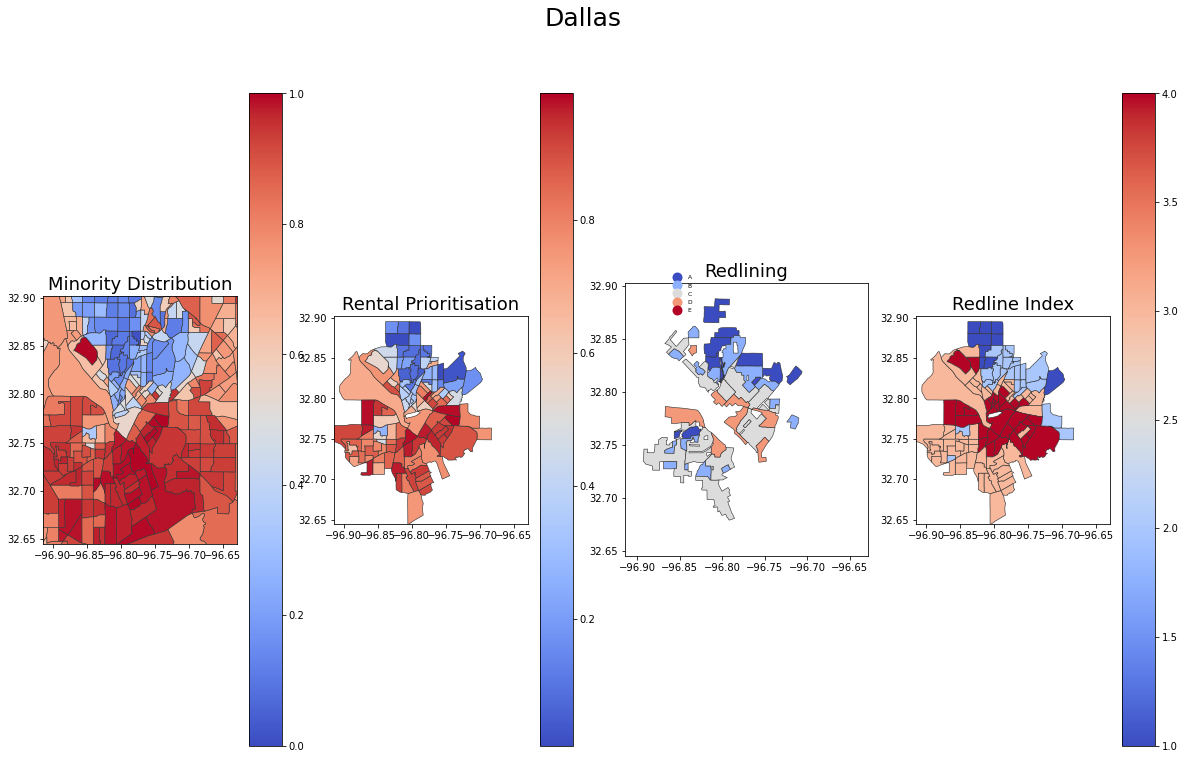

In [ ]:
results('Dallas')

In [ ]:
#Saving the output of correlation in a separate table
correlation_table = pd.DataFrame(columns=['City_name', 'race_rental_corr','rental_redline_corr','rental_redline_spearman','spearman_p_value'])

correlation_table.loc[len(correlation_table)]=['New York',correlation_racial_rental(['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County'],None,['36061000100']),rental_redline_corr(['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County'],ny_rent_data,['36061000100'])[0],rental_redline_corr(['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County'],ny_rent_data,['36061000100'])[1],rental_redline_corr(['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County'],ny_rent_data,['36061000100'])[2]] 
correlation_table.loc[len(correlation_table)]=['Los Angeles',correlation_racial_rental(['Los Angeles County']),rental_redline_corr(['Los Angeles County'],cali_rent_data,['6037401311'])[0],rental_redline_corr(['Los Angeles County'],cali_rent_data,['6037401311'])[1],rental_redline_corr(['Los Angeles County'],cali_rent_data,['6037401311'])[2]]
correlation_table.loc[len(correlation_table)]=['San Francisco',correlation_racial_rental(['San Francisco County'],None,['06075980401']),rental_redline_corr(['San Francisco County'],cali_rent_data,['06075980401'])[0],rental_redline_corr(['San Francisco County'],cali_rent_data,['06075980401'])[1],rental_redline_corr(['San Francisco County'],cali_rent_data,['06075980401'])[2]] 
correlation_table.loc[len(correlation_table)]=['Chicago',correlation_racial_rental(['Cook County'],'Illinois'),rental_redline_corr(['Cook County'],chicago_rent_data,None,'Illinois')[0],rental_redline_corr(['Cook County'],chicago_rent_data,None,'Illinois')[1],rental_redline_corr(['Cook County'],chicago_rent_data,None,'Illinois')[2]] 
correlation_table.loc[len(correlation_table)]=['Detroit',correlation_racial_rental(['Wayne County'],'Michigan',['26163571800']),rental_redline_corr(['Wayne County'],detroit_rent_data,['26163571800'],'Michigan')[0],rental_redline_corr(['Wayne County'],detroit_rent_data,['26163571800'],'Michigan')[1],rental_redline_corr(['Wayne County'],detroit_rent_data,['26163571800'],'Michigan')[2]] 
correlation_table.loc[len(correlation_table)]=['Minneapolis',correlation_racial_rental(['Hennepin County']),rental_redline_corr(['Hennepin County'],minneapolis_rent_data)[0],rental_redline_corr(['Hennepin County'],minneapolis_rent_data)[1],rental_redline_corr(['Hennepin County'],minneapolis_rent_data)[2]] 
correlation_table.loc[len(correlation_table)]=['Newark',correlation_racial_rental(['Essex County'],'New Jersey'),rental_redline_corr(['Essex County'],newark_rent_data,None,'New Jersey')[0],rental_redline_corr(['Essex County'],newark_rent_data,None,'New Jersey')[1],rental_redline_corr(['Essex County'],newark_rent_data,None,'New Jersey')[2]] 
correlation_table.loc[len(correlation_table)]=['Dallas',correlation_racial_rental(['Dallas County'],'Texas'),rental_redline_corr(['Dallas County'],dallas_rent_data,None,'Texas')[0],rental_redline_corr(['Dallas County'],dallas_rent_data,None,'Texas')[1],rental_redline_corr(['Dallas County'],dallas_rent_data,None,'Texas')[2]] 
correlation_table.loc[len(correlation_table)]=['Atlanta',correlation_racial_rental(['Fulton County'],None,['12057980200']),rental_redline_corr(['Fulton County'],atlanta_rent_data,['12057980200'])[0],rental_redline_corr(['Fulton County'],atlanta_rent_data,['12057980200'])[1],rental_redline_corr(['Fulton County'],atlanta_rent_data,['12057980200'])[2]] 
correlation_table.loc[len(correlation_table)]=['Boston',correlation_racial_rental(['Suffolk County'],'Massachusetts'),rental_redline_corr(['Suffolk County'],boston_rent_data,None,'Massachusetts')[0],rental_redline_corr(['Suffolk County'],boston_rent_data,None,'Massachusetts')[1],rental_redline_corr(['Suffolk County'],boston_rent_data,None,'Massachusetts')[2]] 
correlation_table.loc[len(correlation_table)]=['Hoston',correlation_racial_rental(['Harris County'],'Texas'),rental_redline_corr(['Harris County'],houston_rent_data,None,'Texas')[0],rental_redline_corr(['Harris County'],houston_rent_data,None,'Texas')[1],rental_redline_corr(['Harris County'],houston_rent_data,None,'Texas')[2]] 
correlation_table.loc[len(correlation_table)]=['Nashville',correlation_racial_rental(['Davidson County'],'Tennessee'),rental_redline_corr(['Davidson County'],nashville_rent_data,None,'Tennessee')[0],rental_redline_corr(['Davidson County'],nashville_rent_data,None,'Tennessee')[1],rental_redline_corr(['Davidson County'],nashville_rent_data,None,'Tennessee')[2]] 
correlation_table.loc[len(correlation_table)]=['St. Louis',correlation_racial_rental(['St. Louis County']),rental_redline_corr(['St. Louis County'],stlouis_rent_data,None)[0],rental_redline_corr(['St. Louis County'],stlouis_rent_data,None)[1],rental_redline_corr(['St. Louis County'],stlouis_rent_data,None)[2]] 


correlation_table

/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
  warnings.warn(message)
/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)
/opt/venv/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  warnings.warn(message)


,City_name,race_rental_corr,rental_redline_corr,rental_redline_spearman,spearman_p_value
0,New York,0.562351,0.154669,0.148471,1.424442e-08
1,Los Angeles,0.638782,0.328759,0.363125,2.198166e-47
2,San Francisco,0.631768,0.291461,0.307768,4.690547e-05
3,Chicago,0.696917,0.242436,0.236916,2.169033e-14
4,Detroit,0.658485,0.138381,0.246936,1.601457e-07
5,Minneapolis,0.557660,0.488164,0.598400,3.365288e-13
6,Newark,0.834679,0.577305,0.561940,2.236257e-18
7,Dallas,0.557875,0.568388,0.617119,3.747951e-14
8,Atlanta,0.774113,0.368350,0.402715,3.269626e-05
9,Boston,0.502234,0.072656,0.166262,2.655219e-02
